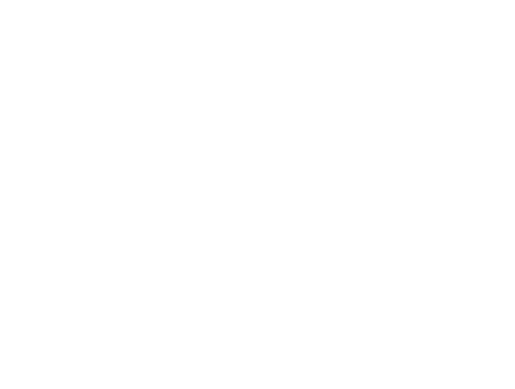

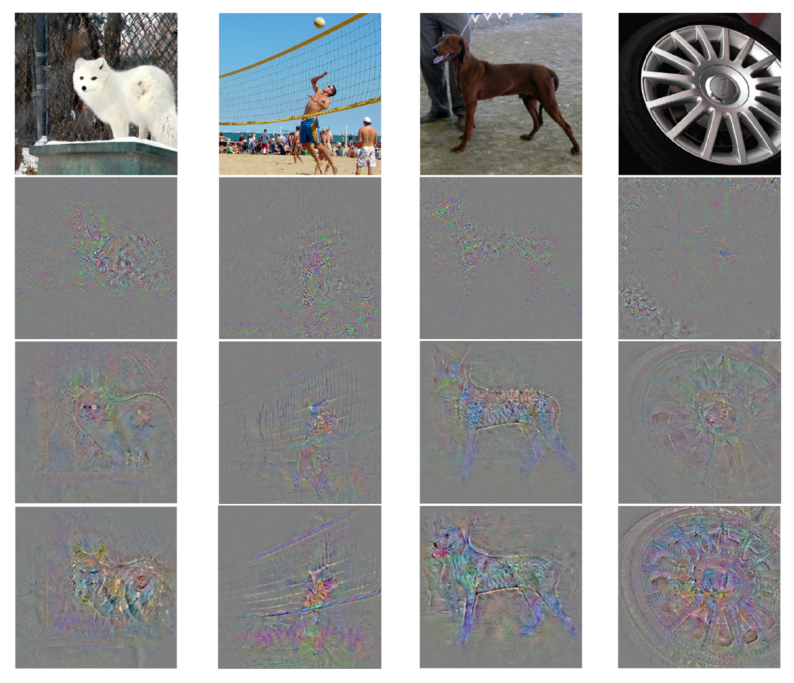

In [13]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from captum.attr import Saliency
from simclr import SimCLR
from algorithms import RegX, AdvX

# Load the pre-trained SimCLR model with ResNet-50 architecture
model = SimCLR(50, 1, 0)
model.load_state_dict(torch.load("simclr_resnet50.pth"))
model.eval()

# Define a function to preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create a saliency attribution object
saliency = Saliency(model)

# Instantiate RegX and AdvX classes
regx = RegX(model, alpha=0.1, feature_importance_function=saliency.attribute)
advx = AdvX(model, beta=0.01, gamma=0.1, feature_importance_function=saliency.attribute)

# Create a subplot for displaying the saliency maps
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4, figsize=(16, 16))

for i in range(4):
    # Load an image from the ImageNet dataset
    image_path = f"img_{i}.png"  # Path to the image file
    image = Image.open(image_path)
    input_image = preprocess(image).unsqueeze(0)

    # Generate the saliency map for the original image
    saliency = Saliency(model)
    original_saliency_map = saliency.attribute(input_image)

    # Apply RegX enhancement to the image
    enhanced_image_regx = regx.enhance_image(input_image.clone())

    # Generate the saliency map for the enhanced image with RegX
    enhanced_saliency_map_regx = saliency.attribute(enhanced_image_regx)

    # Apply AdvX enhancement to the image
    enhanced_image_advx = advx.enhance_image(input_image.clone())

    # Generate the saliency map for the enhanced image with AdvX
    enhanced_saliency_map_advx = saliency.attribute(enhanced_image_advx)

    # Plot the original and enhanced saliency maps
    axs[i, 0].imshow(transforms.ToPILImage()(input_image.squeeze(0)))
    axs[i, 1].imshow(transforms.ToPILImage()(original_saliency_map.squeeze(0)), cmap='hot')
    axs[i, 2].imshow(transforms.ToPILImage()(enhanced_saliency_map_regx.squeeze(0)), cmap='hot')
    axs[i, 3].imshow(transforms.ToPILImage()(enhanced_saliency_map_advx.squeeze(0)), cmap='hot')

# Hide the axes
for ax in axs.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()
plt.savefig("images/img.png")
